# Supervised learning applied to transaction approval

by Giancarlo Marchesi

This notebook contains the analysis for a series of credit scoring models for a direct account payment gateway company.

A payment gateway is a merchant service provided by an e-commerce application service provider that authorizes credit card or direct payments processing for e-businesses, online retailers, bricks and clicks, or traditional brick and mortar. This particular gateway company authorizes direct payments to merchants from customers bank accounts. The gateway has no online connection to banks, so it must rely on its own scoring models to determine which customers to approve. Bad transactions occur when customers do not have funds in their accounts at the time. Merchants get paid immediately, so default risk stays with the gateway company.

The company currently has scores from two credit rating providers, yet has a manual process to approve the transactions. Unless they get specific confirmation by phone from the customer's bank that the customer's account is empty, the transaction is approved. Hence, they are not leveraging the data from the providers. Hence, bad (insolvent) transactions are frequent. The client wants to know how to use the data they have effectively to have a better risk model and be profitable. The sector in which the company operates is risky. The commerces do not take credit cards, only direct payments. Commerces that use these methods are generally in riskier economic activities and therefore, attract riskier clients.

The analysis presents alternative credit socring models using supervised machine learning methods that combine these scores and other available data. The data is from a private direct payment processing company. Only features pertaining to the analysis are shown in the dataset. A logistic regression model and a KNN model will be compared to score 1 and score 2 by themselves as well as the interaction term of both. The hypothesis is that ML models can provide additional insight to the independent scores.   

The result of this analysis should advise the company on a model that will make their business more profitable.

## Exploring the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('data_final_2.csv', sep=";")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.shape

The dataset contains 824 observations and 11 features. 

### Feature description

- `score_1`: client risk category depending on score from provider 1. Five possible categories: excellent, good, medium, bad  and no data (nd)
- `risk_score1`: binary variable according to risk profile from provider 1. Excellent and good are assigned a score of 0. The rest of the categories get a score of 1. 
- `score_2`:  client risk category depending on score from provider 2. Five possible categories: excellent, good, medium, bad  and no data (nd)
- `risk_score2`: binary variable according to risk profile from provider 2. Excellent and good are assigned a score of 0. The rest of the categories get a score of 1. 
- `interaction_1`: interaction term between score_1 and score_2. If both have a score of 1, the variable will be 1, i.e a risky client. In other cases, the variable will be 0.  
- `interaction_2`: its a more stringent definition of risk. Only the combinations of excellent, excellent and good,excellent in both permutations are considered 0. The rest are considered 1 (i.e risky). 
- `transaction`: es is the dollar amount of the transaction
- `bad_transaction`: binary variable where 1 corresponds to a bounced transaction (bad electronic check) and 0 is a succesful transaction (i.e the customer had the necessary funds). 
- `state`: two letters corresponding to the state in the United States
- `population`: binary variable where 1 is assigned to the most populous states: California, Texas, Florida, New York y Pennsylvania 
- `sc_control`: binary variable where 1 is assigned to the state of South Carolina. It has a disproportionate amount of transactions in the dataset for the size of its population. 

## Exploring the features

In [ ]:
## How many transactions are considered risky by the first score?
df.risk_score1.sum()

In [ ]:
## How many transactions are considered risky by the second score?
df.risk_score2.sum()

In [ ]:
## How many transactions were actually bad?
df.bad_transaction.sum()

In [ ]:
## What percentage of transactions are bad? 
153/824

In [ ]:
## How many transactions are considered risky by the first interaction term?
df.interaction_1.sum()

In [ ]:
## How many transactions are considered risky by the second interaction term?
df.interaction_2.sum()

In [ ]:
## The average size of a transaction in USD
df.transaction.mean()

In [ ]:
df[df['bad_transaction']==0]['transaction'].mean()

In [ ]:
df[df['bad_transaction']==1]['transaction'].mean()

The actual bad trasaction number is relatively high (18.56%), which is a good problem to have because we are not facing an unbalanced sample. There should be enough signal from the bad_transactions variable to apply ML. However, the dataset is relatively small. K-fold validation might be a good tool to implement in this case to optimize the hyperparameters and test which alternatives will give us better results. 

It is interersting to note that the bad transactions predicted by Score 1 and Score 2 are somewhere in between `bad transaction`, while the interaction terms seem to be way off. However, this does not mean that either model predicted bad transactions correctly.  We want to calculate the accuracy for each risk score or alternative ML model to get this number.

Bad transactions seem to be slightly larger than good transcations, by $3.5 dollars. 

## The business problem

The economics for the business are as follows: 
- The business loses 100% of bad transactions 
- The business charges 5% of good transactions

According to the dataset, this is the current state of the business: 

In [824]:
## Money lost
lost=df['bad_transaction']*df['transaction']
lost.sum()

11892

In [825]:
## Money made
made=0.05*(df[df['bad_transaction']==0]['transaction'].sum())

In [826]:
made

2490.5

In [827]:
## Profit
profit=made-lost.sum()
profit

-9401.5

The company lost USD 9400 because their credit scoring process is lacking. It does not really account for risk, since it approves most transactions. The CEO wants to know how to reduce bad transactions to increase profits (or decrease losses).  

The analysis will center on finding the best classification model to minimize losses from the following alternatives: 

- Credit Score 1
- Credit Score 2
- Interactions of Score 1 and Score 2 
- Logistic regression model 
- KNN model 

## Model 1: Credit Score 1

The accuracy of Credit Score 1 can be analyzed with a confusion matrix. This classifies transactions in four groups: 

- True positives:  transactions that the score predicted would be good and indeed the customer had funds 
- True negatives:  transactions that the score predicted would be losses and indeed the customer had no funds 
- False positives: transactions that the score predicted would be good but the customer had no funds 
- False negatives: transactions that the score predicted would be losses but did have funds

In [ ]:
## Confusion Matrix for Score 1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generating the confusion matrix  
cf_matrix = confusion_matrix(df.bad_transaction, df.risk_score1)

# where bad_transaction is the actual outcome and risk_score 1 is the predicted outcome

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix).plot(cmap='Greens')
plt.show()

Remember, '1' is a bad transaction, i.e. "a positive" in the nomenclature. 

The matrix is read in the following way: 
    
- True, Predicted (0,0). True negative. The transaction was good and the model predicted it as such. 598
- True, Predicted (1,0). False negative. The transaccion was bad, but the model predicted it would be good. 100
- True, Predicted (1,1). True positives. The transaction was bad and the model predicted it as such. 53
- True, Predicted (0,1). False positive. The transaction was good but the model predicted it would be bad. 73 

In [ ]:
tn=598
fn=100
tp=53
fp=73
sum_all=824

We can use three model evaluation metrics to check which proposed alternative will be better. 

Because accuracy alone can be misleading depending on the class balance of the data, two other metrics are used in conjuction.   

1. Accuracy: percentage of trues that the model gets correctly

2. Precision: measures what proportion of a model assigned to positive are actually members of the positive class: 

3. Recall:  measures how many members of the positive class the model correctly identified out of the total

Using these definitions, accuracy can be written as:

$$Accuracy = \frac{TN+TP}{TN+FP+FN+TP}$$

In [ ]:
accu_score1= (tn + tp )/ sum_all

In [ ]:
accu_score1

Accuracy of score 1 is 79%

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

In [ ]:
prec_score1=tp/(tp+fp)

In [ ]:
prec_score1

The model is not very precise. False positives are more than true positives. 

Recall measures how many members of the positive class the model correctly identified out of the total:

$$Recall = \frac{TP}{TP+FN}$$

In [ ]:
rec_score1=tp/(tp+fn)

In [ ]:
rec_score1

Recall is lacking at 0.34. It classified 100 observations as false negatives.

### Profit

It the business only used this model, fp and tp would have not been accepted as transactions: 73+53 observations would have been labeled as risky. 

In [ ]:
## Calculating the tn dataframe
tndf=df[(df['risk_score1']==0) & (df['bad_transaction']==0)]

In [ ]:
tndf.shape

Indeed it has 598 observations as in the confussion matrix. 

In [ ]:
## Estimating revenue
Revenue_score1=0.05*(tndf['transaction'].sum())

In [ ]:
Revenue_score1

In [ ]:
## Calculating the fn dataframe
fndf=df[(df['risk_score1']==0) & (df['bad_transaction']==1)]

In [ ]:
## indeed the frame has 100 observations as in the confusion matrix
fndf.shape

In [ ]:
loss_score1=(fndf['transaction'].sum())

In [ ]:
loss_score1

In [ ]:
Profit_score1=Revenue_score1-loss_score1

In [ ]:
Profit_score1

So by using the score from provider 1, the company has saved 3972 dollars versus not using a score at all. This is better, but they are still operating at a loss of 5429 dollars. The main problem is that false negatives are very costly, since they lose 100% of the transaction, and these on average are even larger than the good transactions. 

## Model 2: Credit Score 2

In [ ]:
## Confusion Matrix for Score 2

# Generating the confusion matrix  
cf_matrix2 = confusion_matrix(df.bad_transaction, df.risk_score2)

# where bad_transaction is the actual score and risk_score 2 is the predicted score

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix2).plot(cmap='Blues')
plt.show()

In [ ]:
tn2=527
fn2=118
tp2=35
fp2=144
sum_all=824

In [ ]:
accu_score2= (tn2 + tp2)/ sum_all

In [ ]:
accu_score2

Accuracy is lower than for model 1. 

In [ ]:
prec_score2=tp2/(tp2+fp2)

In [ ]:
prec_score2

In [ ]:
rec_score2=tp2/(tp2+fn2)

In [ ]:
rec_score2

So are precission and recall. On all metrics, it is inferior to model 1. Hence, loss will be worse. No need to calculate profit here.   

## Model 3: Interaction  of Score 1 & Score 2

In [ ]:
df.interaction_1.sum()

In [ ]:
df.interaction_2.sum()

Interaction term 2 at least has a chance to catch all positives, but it's clear it will have a problem with false positives, reducing revenue for the company. Let's at least conduct the exercise to calculate profits under this model. 

In [ ]:
## Confusion Matrix for interaction term 2

# Generating the confusion matrix  
cf_matrix3 = confusion_matrix(df.bad_transaction, df.interaction_2)

# where bad_transaction is the actual score and interaction_2 is the predicted score

# Displaying the confusion matrix
ConfusionMatrixDisplay(cf_matrix3).plot(cmap='Reds')
plt.show()

As expected, false positives are an issue, and the model only catches a bit more then half of the true positives. 

In [ ]:
tn3=434
fn3=67
tp3=86
fp3=237

In [ ]:
accu_score3= (tn3 + tp3)/ sum_all
prec_score3=tp3/(tp3+fp3)
rec_score3=tp3/(tp3+fn3)

In [ ]:
accu_score3

In [ ]:
prec_score3

In [ ]:
rec_score3

Since the recall score is the best seen so far, this could help the bottom line if it overcomes the tradeoff for loss in revenue from the false positives. 

In [ ]:
## Calculating the tn dataframe
tndf3=df[(df['interaction_2']==0) & (df['bad_transaction']==0)]

In [ ]:
tndf3.shape

In [ ]:
## Calculating the fn dataframe
fndf3=df[(df['interaction_2']==0) & (df['bad_transaction']==1)]

In [ ]:
fndf3.shape

In [ ]:
## Estimating revenue
Revenue3=0.05*(tndf3['transaction'].sum())

In [ ]:
Revenue3

Total revenue takes a substantial hit from losing the false positive revenue

In [ ]:
loss3=(fndf3['transaction'].sum())

In [ ]:
Profit3=Revenue3-loss3

In [ ]:
Profit3

This is the best model so far, as the loss is smallest, USD 3607. This is because recall is the most important of the measures in terms for this particular business model. 

## Model 4: Logistic Regression

### Using Scikit Learn

The objective of this model is to improve on the profit of the previous scores. 
To use a logistic regression model with this data, I want to follow the next steps: 
- Separate features and target 
- Scale the data
- Optimize hyperparameters with k-fold validation
- Fit model
- Evaluate 

Since data is scarce, I will not be separating into the traditional train-test split. This is an ananlysis to help guide the company. With more data, and before taking the model to production, this could be done. 

In [ ]:
df.info()

In [ ]:
# Step 1: Separating the features and target
X = df.iloc[:, [1,3,4,5,6,9,10]]
y = df.iloc[:,7]

# adding an intercept
X = sm.add_constant(X)

In [ ]:
X

Most are dummies except for transaction amount. Hence, we'll need to scale. 

In [ ]:
y

In [ ]:
## Additional libraries needed 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import random
np.random.seed(123)
random.seed(123)


In [ ]:
## Step 2: Scaling the data

# create an instance
scaler = StandardScaler()

# fit to training set
scaler.fit(X)

# transform both train & test sets
X_scaled = scaler.transform(X)


In [ ]:
## Step 3: optimizing parameters with K-fold validation 
## I'm trying to maximize recall. As we saw earlier, this is the most relevant score for profit

cross_validation_scores = []

C_range = np.array([.0000001,.000001,.00001,.0001,.001,.01, .1, 1,10,100,1000,10000,100000])

#Do some cross validation
for c in C_range:
    LR_model = LogisticRegression(C=c,random_state=1)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model, X_scaled, y, cv = 5, scoring='recall'))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

Numbers above 1 seem to be the best for maximizing recall. However, it's not very good. 

In [ ]:
## Step 4: fit the model 

# 1. Instanitate model
logreg = LogisticRegression(random_state=1, C=1)

# fit to training sets
logreg.fit(X_scaled, y)

# make predictions for train and test sets
y_pred = logreg.predict(X_scaled)



In [ ]:
# Look at confusion matrix for training set
cm_val = confusion_matrix(y, y_pred)
print(cm_val)

# Use the nice display
ConfusionMatrixDisplay(cm_val).plot()

In [ ]:
# classification report on the training data
print(classification_report(y, y_pred))

The recall of this model is bad. No need to calculate profits here. 

We have tried the scikit learn method, but we can also run the regression using the statsmodels api and setting the threshold differently, to reduce the number of false negatives. 

### Using the statsmodel API

In [ ]:
## New library imported
import statsmodels.api as sm

In [ ]:
# Instatiating
logreg2= sm.Logit(y, X)

# Fitting
logreg2_results = logreg2.fit()

# Priting the results
logreg2_results.summary()

Not all variables are statistically relevant, but we will keep them all to try to capture the greatest amount of variance. 

**Calculating odds ratios**

In [ ]:
# defining the sigmoid curve manually
def sigmoid_curve(x):
    return 1 / (1 + np.exp(-x)) # exp(x) is the function to calculate e^x

In [ ]:
logreg2_results.params 

**Explaining some of the coeficcients**

In [ ]:
beta0 = logreg2_results.params[0]
beta1 = logreg2_results.params[1]
beta2 = logreg2_results.params[2]
beta3 = logreg2_results.params[3]
beta4 = logreg2_results.params[4]
beta5 = logreg2_results.params[5]
beta6 = logreg2_results.params[6]
beta7 = logreg2_results.params[7]

**For the constant**

In [ ]:
np.exp(beta0)

The odds of a transaction being bad are 0.06. Let's plug this into the sigmoid curve to get the probability. 

In [ ]:
probability_of_badtransaction = sigmoid_curve(beta0)

In [ ]:
probability_of_badtransaction

The probability of a bad transaction according to this model is 0.06. Yet we know that 18% of the transactions are bad. 

**For risk score 1**

In [ ]:
np.exp(beta1)

If risk_score1 is 1, the odds increase to 3.19

In [ ]:
linear_combo=beta0+1*beta1

In [ ]:
probability_of_badtransaction = sigmoid_curve(linear_combo)

In [ ]:
probability_of_badtransaction

By itself, if score1 is risky, the probability of being a bad transaction is 0.176. This is not an auspicious result. A lot of the variance is not being picked up by this score. 

**For risk score 2**

In [ ]:
np.exp(beta2)

If risk_score2 is 1, the odds increase to 0.32

In [ ]:
linear_combo=beta0+1*beta2
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

By itself, if score2 is risky, the probability of being a bad transaction is 0.02. Hence, score 2 does not tell us much by itself.

**For interaction term 1**

In [ ]:
linear_combo=beta0+1*beta3
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

By itself, if the interaction term considers the client risky, the probability of having a bad transaction is 0.129

**For the average size transaction**

In [ ]:
linear_combo=beta0+75*beta5
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

By itself, an average size transaction has a probability of 0.13 of being bad. 

In [ ]:
##Grading the whole model. 
linear_combo=beta0+1*beta1+1*beta2+1*beta3+1*beta4+75*beta5+1*beta6+1*beta7
probability_of_badtransaction = sigmoid_curve(linear_combo)
probability_of_badtransaction

For an average size transaction with all the risk markers on, the probability of it being bad is 0.32. Let see if we can fix the false negative problems by adjusting the threshold in the model towards this amount.  

In [ ]:
## Getting the probability predictions for each observation 
model_predictions_prob=logreg2_results.predict(X)

In [ ]:
## Setting the threshold at 0.5 and creating a binary predictions column
model_predictions_binary = np.where(model_predictions_prob>0.5,1,0)

In [ ]:
model_predictions_binary.sum()

As we can see the model only predicts 50 bad transactions, when we know there are 157.If we decrease the thresold, it will tend to capture some more of those false negatives.  

In [ ]:
## creating a for loop to optimize the recall 
threshold=[0.5, 0.45, 0.40, 0.35,0.30, 0.25, 0.20, 0.15]

for i in threshold: 
    model_predictions_binary = np.where(model_predictions_prob>i,1,0)
    cm_val3 = confusion_matrix(y, model_predictions_binary)
    ConfusionMatrixDisplay(cm_val3).plot() 
    print(f'The used threshold is {i}')
    print(classification_report(y, model_predictions_binary))

Recall continues to increase as the threshold is lowered, though false positives are also going up. So losses are diminishing but so is revenue. Hence, the business side will have decide on this trade-off as false positives will alineate potential future customers. 

#### Estimating profits for 0.3 and 0.15 thresholds

This recall score is lower than the interaction model. Let's see in terms of profit were it stands 

In [775]:
## incorporating the predictions in the dataframe for threshold 0.3
model_predictions_binary = np.where(model_predictions_prob>0.3,1,0)
df['predictions_log']=model_predictions_binary

In [776]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
 11  predictions_log  824 non-null    int32 
dtypes: int32(1), int64(8), object(3)
memory usage: 74.2+ KB


In [778]:
df.predictions_log.sum()

143

In [779]:
tndf4=df[(df['predictions_log']==0) & (df['bad_transaction']==0)]

In [780]:
tndf4.shape

(588, 12)

In [781]:
## Calculating the fn dataframe
fndf4=df[(df['predictions_log']==0) & (df['bad_transaction']==1)]

In [782]:
## Estimating revenue
Revenue4=0.05*(tndf4['transaction'].sum())

In [783]:
Revenue4

2147.0

In [784]:
loss4=(fndf4['transaction'].sum())

In [785]:
loss4

6788

In [786]:
Profit4=Revenue4-loss4

In [787]:
Profit4

-4641.0

The loss using a threshold of 0.3 is still higher than the model for intearction term 1. 

In [788]:
## incorporating the predictions in the dataframe for threshold 0.15
model_predictions_binary = np.where(model_predictions_prob>0.15,1,0)
df['predictions']=model_predictions_binary

In [789]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   transaction      824 non-null    int64 
 7   bad_transaction  824 non-null    int64 
 8   state            823 non-null    object
 9   population       824 non-null    int64 
 10  sc_control       824 non-null    int64 
 11  predictions_log  824 non-null    int32 
 12  predictions      824 non-null    int32 
dtypes: int32(2), int64(8), object(3)
memory usage: 77.4+ KB


In [790]:
df.predictions.sum()

325

In [791]:
tndf4=df[(df['predictions']==0) & (df['bad_transaction']==0)]

In [792]:
tndf4.shape

(445, 13)

In [793]:
## Calculating the fn dataframe
fndf4=df[(df['predictions']==0) & (df['bad_transaction']==1)]

In [794]:
fndf4.shape

(54, 13)

This model has substantially reduced the true negatives and the false negatives. Let's see how it plays out in terms of profits. 

In [795]:
## Estimating revenue
Revenue4=0.05*(tndf4['transaction'].sum())

In [796]:
Revenue4

1556.3000000000002

In [797]:
loss4=(fndf4['transaction'].sum())

In [798]:
loss4

3956

In [799]:
Profit4=Revenue4-loss4

In [800]:
Profit4

-2399.7

So this model does a better job of minimizing losses. However, the business development team needs to weigh in because customer lifetime value for the upset customers in the false positives will likely fall. This is not an easy trade-off. 

## Model 5: KNN

In [801]:
from sklearn.neighbors import KNeighborsClassifier

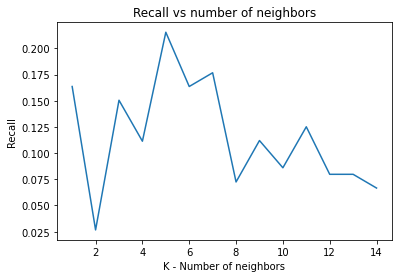

In [802]:
## K-folds cross validation for the Number of Neighbors parameter

# Define our list of k values to try out. We'll try 15 values. The dataset is small. 
k_values = list(range(1, 15,))

# Create a list to hold our cross-validation scores
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, scoring='recall', cv=5)
    cv_scores.append(np.mean(scores))
    
plt.figure()
plt.plot(k_values, cv_scores, label="mean score")
plt.xlabel('K - Number of neighbors')
plt.ylabel('Recall')
plt.title("Recall vs number of neighbors")
plt.show()    

The highest recall is achieved at 5 neighbors. We'll run the model with this parameter. 

In [803]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)

KNeighborsClassifier()

In [804]:
## generating predictions
y_pred_knn = knn.predict(X_scaled)

In [805]:
## including them in the df
df.loc[:,'pred_prob_knn']=y_pred_knn

In [573]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   score_1          824 non-null    object
 1   risk_score1      824 non-null    int64 
 2   score_2          824 non-null    object
 3   risk_score2      824 non-null    int64 
 4   interaction_1    824 non-null    int64 
 5   interaction_2    824 non-null    int64 
 6   risk_quant       824 non-null    int64 
 7   transaction      824 non-null    int64 
 8   bad_transaction  824 non-null    int64 
 9   state            823 non-null    object
 10  population       824 non-null    int64 
 11  sc_control       824 non-null    int64 
 12  predictions      824 non-null    int32 
 13  pred_prob_knn    824 non-null    int64 
dtypes: int32(1), int64(10), object(3)
memory usage: 87.0+ KB


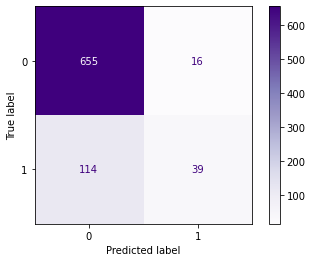

In [806]:
# generando la matriz de confusion 
cf_matrix = confusion_matrix(df.bad_transaction, df.pred_prob_knn)

# presentando la matriz
ConfusionMatrixDisplay(cf_matrix).plot(cmap='Purples')
plt.show()

The recall is inferior to previous alternatives.

In [807]:
tndf5=df[(df['pred_prob_knn']==0) & (df['bad_transaction']==0)]

In [808]:
tndf5.shape

(655, 14)

In [809]:
fndf5=df[(df['pred_prob_knn']==0) & (df['bad_transaction']==1)]

In [810]:
fndf5.shape

(114, 14)

In [579]:
Revenue5=0.05*(tndf5['transaction'].sum())

In [811]:
Revenue5

2423.25

In [812]:
loss5=(fndf5['transaction'].sum())

In [813]:
loss5

8713

In [814]:
Profit5=Revenue5-loss5

In [815]:
Profit5

-6289.75

This model is inferior to the previous ones. 

### An alternative KNN

What would happened if we used unscaled data for X instead? 

In [820]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X, y)

KNeighborsClassifier()

In [821]:
## generating predictions
y_pred_knn2 = knn.predict(X)

In [822]:
## including them in the df
df.loc[:,'pred_prob_knn2']=y_pred_knn2

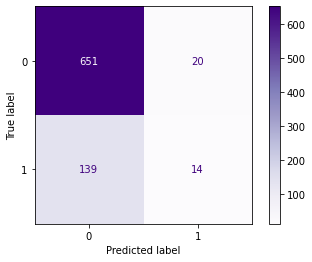

In [823]:
# generando la matriz de confusion 
cf_matrix = confusion_matrix(df.bad_transaction, df.pred_prob_knn2)

# presentando la matriz
ConfusionMatrixDisplay(cf_matrix).plot(cmap='Purples')
plt.show()

Not much happened. It is infact, worse. Only 14 true positives identified. 

## Conclusion

- The company is losing money and needs to introduce a risk scoring system of some sorts. 
- In terms of practicality, since the company is already paying for but not using Score 1 or Score 2, it an begin filtering clients using an interaction term of the two. I have used the more stringent definition of risk. Only the combinations of (excellent, excellent) and (good,excellent) in both permutations are considered 0. The rest are considered 1 (i.e risky). 
- When this simple model is used, the loss dimishes from 9400 dollars to 3607. This can be implemented right away so the company loses less money. 
- There are not enough observations yet to conduct a proper ML analysis with train and test sets. 
- Nevertheless, the logistic regression model does provide a smaller loss when the threshold for positivity is lowered to 0.15. This is indicative of insuficient data, not just in quantity but perhaps also in additional features to explain the target. 
- Applying the logistic model right now has a commercial trade-off: smaller losses versus more false positives from potentially angry recurring customers. This could affect customer lifetime value in the future and the company's reputation.  